In [173]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [174]:
newdata = pd.read_table('PDCMAP.txt', sep='\s+')

In [175]:
alltime= np.array(newdata['Time'], 'd')
allflux = np.array(newdata['Pdcmap'], 'd')
allquarter = np.array(newdata['Quarter'], 'd')

55001 64024


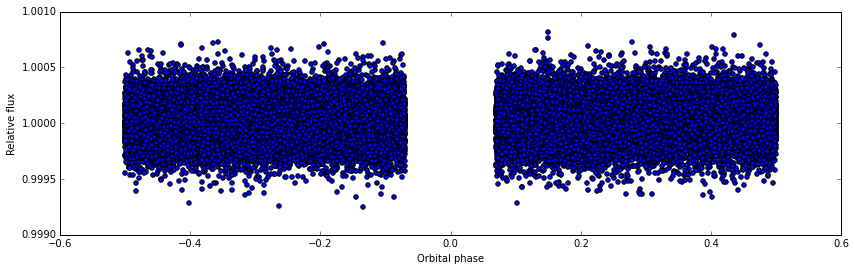

In [176]:
flag = np.zeros(len(alltime), dtype=bool)
quarters = np.unique(allquarter)

# Renormalize each quarter and remove outliers
for q in quarters:
    sel = allquarter == q
    errorf = np.std(allflux[sel])
    medianf = np.median(allflux[sel])
    finsel = np.logical_and(allquarter == q, (np.abs(allflux-medianf) <= 4.0*errorf))
    allflux[finsel] = allflux[finsel]/np.median(allflux[finsel])
    flag[finsel] = True
    
# Remove points in transit
t0 = 53.1910
p = 0.6892099

phasesaux = (alltime-t0)/p
phases = phasesaux - np.around(phasesaux)
flag[np.abs(phases) < 0.07]= False
    
#Retain the right points
print np.sum(flag), len(flag)
time = alltime[flag]
flux = allflux[flag]
quarter = allquarter[flag]
phases = phases[flag]

#plot the folded light curve to make sure we removed transits
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(1,1,1)
ax.scatter(phases, flux)
plt.ylim([0.999,1.001]) 
ax.set_ylabel('Relative flux')
ax.set_xlabel('Orbital phase')



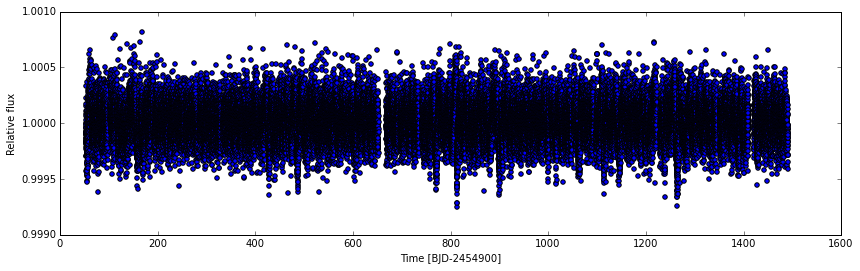

In [177]:
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(1,1,1)
ax.scatter(time, flux)
plt.xlim([0,1600]) 
plt.ylim([0.999,1.001]) 
ax.set_xlabel('Time [BJD-2454900]')
ax.set_ylabel('Relative flux')

In [178]:
time = time-min(time)
num_time = len(time)
delta_t = time[1:num_time]-time[0:num_time-1]
cadence = np.median(delta_t)
range_time = np.max(time)-np.min(time)

gap = delta_t/cadence
gap = np.around(gap)
gap = np.append(gap, 1)

gap_cut = 1.1   
gap_loc = [i for i in np.arange(len(gap)) if (gap[i] > gap_cut)]
num_gap = len(gap_loc)

num_cad  = np.sum(gap)
flux_cad = np.empty(num_cad)

oldflux_st = 0
newflux_st = 0


for n in np.arange(num_gap):
    oldflux_ed = gap_loc[n]
    gap_sz     = gap[gap_loc[n]]
    newflux_ed = newflux_st+(oldflux_ed-oldflux_st)
    
    flux_cad[newflux_st:newflux_ed+1] = flux[oldflux_st:oldflux_ed+1]
    
    gap_fill = (np.ones(gap_sz-1))*flux[oldflux_ed]
    
    flux_cad[newflux_ed+1:newflux_ed+gap_sz] = gap_fill
    
    oldflux_st = oldflux_ed+1
    newflux_st = newflux_ed+gap_sz
    
flux_cad[newflux_st:num_cad] = flux[oldflux_st:num_time]


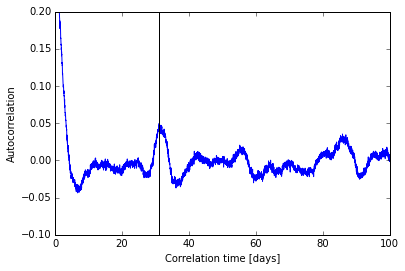

The rotation period is 31.06


In [179]:
yunbiased = flux_cad-np.mean(flux_cad)
ynorm = np.sum(yunbiased**2)
acor = np.correlate(yunbiased, yunbiased, "same")/ynorm

acor = acor[len(acor)/2:]
vec = cadence*np.arange(len(acor))

plt.plot(vec, acor)
plt.xlim([0, 100]) 
plt.ylim([-0.1, 0.2]) 
plt.ylabel('Autocorrelation')
plt.xlabel('Correlation time [days]')



reducedcor = acor[np.abs(vec-30) < 10]
reducedvec = vec[np.abs(vec-30) < 10]

theperiod = reducedvec[np.argmax(reducedcor)]

plt.plot((theperiod, theperiod), (-100,100), 'k-')


plt.show()

print('The rotation period is {0:3.2f}' .format(theperiod))

